# Ciencia de Datos I<a class="tocSkip">
## Electiva Procesamiento de Señales I <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Character Recognition using Fourier Descriptors



## Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2
from   scipy.ndimage import binary_fill_holes
from   skimage.segmentation import find_boundaries

# Example: Recognition of 4 characters

In this example, the extraction of features necessary to perform a recognition of the following four characters with different sizes and different orientations is performed.

* Class 0: period '.'

* Class 1: tilde '~'.

* Class 2: asterisk '~'.

* Class 4: comma ','

 The Fourier descriptors are used for the solution since they are invariant to rotation and scale.

In this example the classification is not performed, only the extraction of Fourier descriptors is shown.

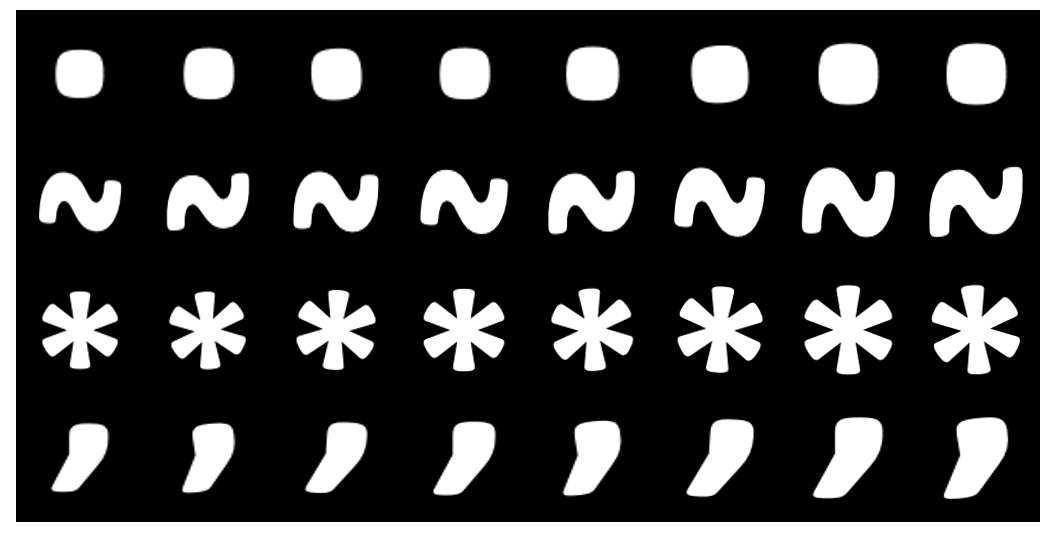

# Database

The database consists of 4 classes and 30 images per class.

# Carga de base de datos
# Se utiliza el archivo chars.zip que se encuentra en el Github

# Funiones Básicas

In [7]:
def efd_descriptors(contour, order=10, normalize=True):
  """Calculate elliptical Fourier descriptors for a contour.
  :param numpy.ndarray contour: A contour array of size ``[M x 2]``.
  :param int order: The order of Fourier coefficients to calculate.
  :param bool normalize: If the coefficients should be normalized;
      see references for details.
  :param bool return_transformation: If the normalization parametres should be returned.
      Default is ``False``.
  :return: A ``[order x 4]`` array of Fourier coefficients and optionally the
      transformation parametres ``scale``, ``psi_1`` (rotation) and ``theta_1`` (phase)
  :rtype: ::py:class:`numpy.ndarray` or (:py:class:`numpy.ndarray`, (float, float, float))
  """
  dxy = np.diff(contour, axis=1)
  dxy = dxy.reshape(dxy.shape[1],2)
  dt = np.sqrt((dxy ** 2).sum(axis=1))
  t = np.concatenate([([0.0]), np.cumsum(dt)])
  T = t[-1]

  phi = (2 * np.pi * t) / T

  orders = np.arange(1, order + 1)
  consts = T / (2 * orders * orders * np.pi * np.pi)
  phi = phi * orders.reshape((order, -1))

  d_cos_phi = np.cos(phi[:, 1:]) - np.cos(phi[:, :-1])
  d_sin_phi = np.sin(phi[:, 1:]) - np.sin(phi[:, :-1])

  a = consts * np.sum((dxy[:, 0] / dt) * d_cos_phi, axis=1)
  b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
  c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
  d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)

  coeffs = np.concatenate(
    [
      a.reshape((order, 1)),
      b.reshape((order, 1)),
      c.reshape((order, 1)),
      d.reshape((order, 1)),
    ],
    axis=1,
  )

  if normalize:
    theta_1 = 0.5 * np.arctan2(
      2 * ((coeffs[0, 0] * coeffs[0, 1]) + (coeffs[0, 2] * coeffs[0, 3])),
      (
              (coeffs[0, 0] ** 2)
              - (coeffs[0, 1] ** 2)
              + (coeffs[0, 2] ** 2)
              - (coeffs[0, 3] ** 2)
      ),
    )
    # Rotate all coefficients by theta_1.
    for n in range(1, coeffs.shape[0] + 1):
      coeffs[n - 1, :] = np.dot(
        np.array(
          [
            [coeffs[n - 1, 0], coeffs[n - 1, 1]],
            [coeffs[n - 1, 2], coeffs[n - 1, 3]],
          ]
        ),
        np.array(
          [
            [np.cos(n * theta_1), -np.sin(n * theta_1)],
            [np.sin(n * theta_1), np.cos(n * theta_1)],
          ]
        ),
      ).flatten()

    # Make the coefficients rotation invariant by rotating so that
    # the semi-major axis is parallel to the x-axis.
    psi_1 = np.arctan2(coeffs[0, 2], coeffs[0, 0])
    psi_rotation_matrix = np.array(
      [[np.cos(psi_1), np.sin(psi_1)], [-np.sin(psi_1), np.cos(psi_1)]]
    )
    # Rotate all coefficients by -psi_1.
    for n in range(1, coeffs.shape[0] + 1):
      coeffs[n - 1, :] = psi_rotation_matrix.dot(
        np.array(
          [
            [coeffs[n - 1, 0], coeffs[n - 1, 1]],
            [coeffs[n - 1, 2], coeffs[n - 1, 3]],
          ]
        )
      ).flatten()

    size = coeffs[0, 0]
    # Obtain size-invariance by normalizing.
    coeffs /= np.abs(size)
  X = coeffs.reshape(4*order,)

  return X

def efourierdes(R, order=10, names=False):
  # Elliptic Fourier Descriptors from https://github.com/hbldh/pyefd
  R8h    = binary_fill_holes(R).astype(np.uint8)
  contours, hierarchy = cv2.findContours(R8h, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  X = efd_descriptors(contours, order=order)

  if names==True:
    Xn = []
    for k in range(order):
      Xn.append('Fourierdes-a-'+str(k))
      Xn.append('Fourierdes-b-'+str(k))
      Xn.append('Fourierdes-c-'+str(k))
      Xn.append('Fourierdes-d-'+str(k))
    return X,Xn
  else:
    return X

from   skimage.segmentation import find_boundaries
from   scipy.ndimage import binary_fill_holes


def fourierdes(R, n_des=16, names=False):

  R8h    = binary_fill_holes(R).astype(np.uint8)
  contour, hierarchy = cv2.findContours(R8h, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  x = np.array(contour)
  B = x.reshape(x.shape[1],2)
  V = B[:, 0] + 1j * B[:, 1]
  m = B.shape[0]

  r = np.zeros(m, dtype=complex)
  phi = np.zeros(m)
  dphi = np.zeros(m)
  l = np.zeros(m)
  dl = np.zeros(m)

  r[0] = V[0] - V[m-1]
  r[1:] = V[1:] - V[:m-1]

  dl = np.abs(r)
  phi = np.angle(r)

  dphi[:m-1] = np.mod(phi[1:] - phi[:m-1] + np.pi, 2 * np.pi) - np.pi
  dphi[m-1] = np.mod(phi[0] - phi[m-1] + np.pi, 2 * np.pi) - np.pi

  l[0] = dl[0]
  for k in range(1, m):
    l[k] = l[k-1] + dl[k]

  l = l * (2 * np.pi / l[m-1])
  descriptors = np.zeros(n_des)

  for n in range(1, n_des + 1):
    an = (dphi * np.sin(l * n)).sum()
    bn = (dphi * np.cos(l * n)).sum()
    an = -an / n / np.pi
    bn = bn / n / np.pi
    imagi = an + 1j * bn
    descriptors[n-1] = np.abs(imagi)

  X = descriptors

  if names:
    return np.array([f'Fourier-des {n+1:>2d}' for n in range(n_des)]), descriptors
  return X

def plot_features(X,d,st,show=1):
  dmin = int(np.min(d))
  dmax = int(np.max(d))
  for j in range(dmin,dmax+1):
    plt.scatter(X[d==j,0],X[d==j,1],label='Class '+str(j),cmap=plt.cm.autumn,s=17)
  plt.grid(True)
  plt.legend()
  plt.xlabel('$x_1$',fontsize=14)
  plt.ylabel('$x_2$',fontsize=14)
  plt.title('Feature Space - '+st,fontsize=14)
  if show==1:
    plt.show()

def num2fixstr(x,d):
  st = '%0*d' % (d,x)
  return st

def imageload(prefix,num_class,digits_class,num_img,digits_img,sep='_',echo='off'):
  st   = prefix + num2fixstr(num_class,digits_class) + sep + num2fixstr(num_img,digits_img) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img      

# Feature Extraction

In [3]:
K = 4  # número de clases
N = 30 # número de imágenes por clase

order = 10
M  = 16            # numero de descriptores
#M  = order*4       # numero de descriptores elipticos

X = np.zeros((K*N,M))               # K x N muestras (filas), y M características (columnas)
y = np.zeros((K*N,))                # ground truth (clasificacion ideal)

t = 0
for j in range(K):                  # para cada clase
  for i in range(N):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = imageload('chars/char_',j+1,2,i+1,3,echo='on')
    # Extracción de características
    R      = (img>0.5)*1             # segmentation
    f = fourierdes(R)                # fourier descriptors
    #f = efourierdes(R,order=order)   # elliptic fourier descriptors
    f = f/np.linalg.norm(f)          # normalizacion

    X[t,:] = f
    y[t] = j
    t = t+1


loading image chars/char_01_001.png...
loading image chars/char_01_002.png...
loading image chars/char_01_003.png...
loading image chars/char_01_004.png...
loading image chars/char_01_005.png...
loading image chars/char_01_006.png...
loading image chars/char_01_007.png...
loading image chars/char_01_008.png...
loading image chars/char_01_009.png...
loading image chars/char_01_010.png...
loading image chars/char_01_011.png...
loading image chars/char_01_012.png...
loading image chars/char_01_013.png...
loading image chars/char_01_014.png...
loading image chars/char_01_015.png...
loading image chars/char_01_016.png...
loading image chars/char_01_017.png...
loading image chars/char_01_018.png...
loading image chars/char_01_019.png...
loading image chars/char_01_020.png...
loading image chars/char_01_021.png...
loading image chars/char_01_022.png...
loading image chars/char_01_023.png...
loading image chars/char_01_024.png...
loading image chars/char_01_025.png...
loading image chars/char_

# Visualization

Fourier Descriptor : (1, 4)


C:\Users\joser\AppData\Local\Temp\ipykernel_2796\3465933991.py:166: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[d==j,0],X[d==j,1],label='Class '+str(j),cmap=plt.cm.autumn,s=17)


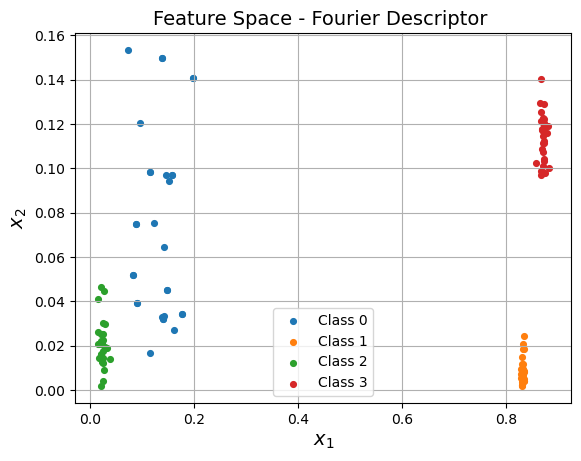

In [4]:
f1 = 1  # Fourier Descriptor f1
f2 = 4  # Fourier Descriptor  f2

print('Fourier Descriptor : '+str((f1,f2)))

Xs = X[:,[f1,f2]]

plot_features(Xs,y,'Fourier Descriptor ',show=1)


From the above graph, one can think that a classifier could work correctly using thresholds for x1 and for x2.


# Similarity matrix

Since each character has been described as a vector (of 16 elements) of norm one, a dot product of all with all can be performed. In this way products that are close to 1 indicate that these vectors are similar.

In this example, in the 120x16 element matrix X, there are 30 vectors for each character, so dot products between vectors of the same class should give values close to 1 (the whole diagonal is 1.0), while dot products of vectors between different classes should give values much smaller than 1. It is observed that class 3 with class 1, however, gives similar vectors (the dot product is about 0.84).

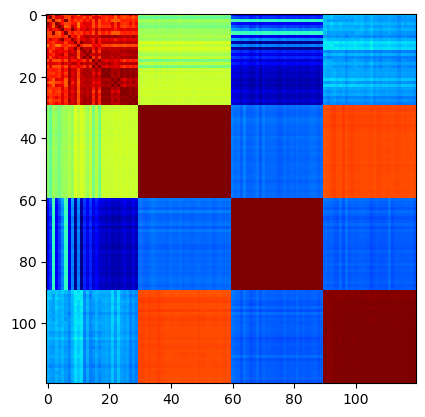

In [5]:
D      = np.dot(X,X.T)
fig    = plt.figure()
ax     = fig.add_subplot(111)
implot = plt.imshow(D,cmap='jet')

In this heat map, colors close to red indicate values close to 1, while colors close to blue indicate values close to 0.

A classifier could be designed using nearest neighbors, i.e. for a new testing image, the Fourier vector normalized to 1 is extracted, the dot product is done with all the rows of X and that class is chosen from the k most similar samples of X with the most votes.

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).